In [1]:
import pandas as pd
from pandas import DataFrame
import requests
import os
import os.path
import datetime as dt
import json
import numpy as np
from datetime import timedelta, datetime
from dateutil import parser
import math
%matplotlib inline
from matplotlib import pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import warnings
warnings.filterwarnings('ignore')

In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# Load environment variables 
binance_api_key = os.getenv("BINANCE_API_KEY")
binance_secret_key= os.getenv("BINANCE_SECRET_KEY")



In [3]:
type(binance_api_key)

str

In [4]:
## Set up client 
from binance.client import Client
binance_client = Client(api_key=binance_api_key, api_secret=binance_secret_key)

# Constants
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

# Create collecting new data function
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2015', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

# Create function to retreive tickers and timestamps
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2015', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [5]:
symbols = ['LINKBTC', 'VETBTC', 'WTCBTC']

In [6]:
# Get waltonchain data
wtc_data=get_all_binance('WTCBTC', '1h')
wtc_data.head()

All caught up..!


,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2017-08-27 04:00:00,0.00015000,0.00017800,0.00010400,0.00015300,1203240.22800000,1503809999999,159.29571314,813,598931.67000000,82.21091722,16522792.51610449
2017-08-27 05:00:00,0.00015300,0.00015500,0.00013100,0.00013500,299651.69000000,1503813599999,42.26205771,271,55659.83000000,8.08788826,16571126.47902449
2017-08-27 06:00:00,0.00013500,0.00014100,0.00013400,0.00014100,163308.16000000,1503817199999,22.42105794,123,66886.80000000,9.22893294,16577903.38991449
2017-08-27 07:00:00,0.00014000,0.00014600,0.00013700,0.00014500,120267.00000000,1503820799999,16.87734096,151,65296.68000000,9.22351637,16614162.11541449
2017-08-27 08:00:00,0.00014500,0.00016000,0.00014200,0.00015400,291830.53000000,1503824399999,44.14270472,320,181886.24000000,27.56069815,16617318.24501449


In [7]:
wtc_data=wtc_data.loc[:,['high', 'low', 'close']]

In [8]:
wtc_data=wtc_data.apply(pd.to_numeric)

In [9]:
wtc_data = wtc_data.loc['2020-06-11 01:00:00':'2020-07-11 01:00:00']

In [10]:
#Create the "L14" column in the DataFrame
wtc_data['L14'] = wtc_data['low'].rolling(window=14).min()

In [11]:
#Create the "H14" column in the DataFrame
wtc_data['H14'] = wtc_data['high'].rolling(window=14).max()

In [12]:
#Create the "%K" column in the DataFrame
wtc_data['%K'] = 100*((wtc_data['close'] - wtc_data['L14']) / (wtc_data['H14'] - wtc_data['L14']))

In [13]:
#Create the "%D" column in the DataFrame
wtc_data['%D'] = wtc_data['%K'].rolling(window=3).mean()

In [14]:
wtc_data.tail()

,high,low,close,L14,H14,%K,%D
timestamp,,,,,,,
2020-07-10 21:00:00,0.000043,0.000042,0.000043,0.000042,0.000043,61.111111,53.439153
2020-07-10 22:00:00,0.000043,0.000042,0.000043,0.000042,0.000043,55.555556,59.259259
2020-07-10 23:00:00,0.000043,0.000042,0.000043,0.000042,0.000043,72.222222,62.962963
2020-07-11 00:00:00,0.000044,0.000043,0.000043,0.000042,0.000044,94.736842,74.171540
2020-07-11 01:00:00,0.000044,0.000043,0.000044,0.000042,0.000044,94.444444,87.134503


Text(0.5, 1.0, 'oscillator')

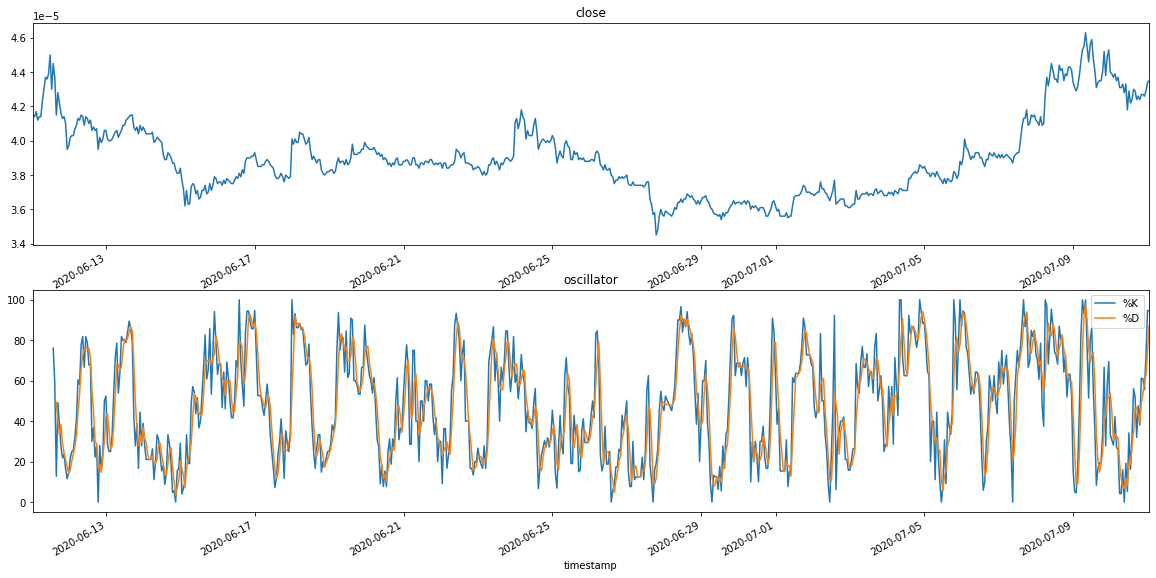

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
wtc_data['close'].plot(ax=axes[0]); axes[0].set_title('close')
wtc_data[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('oscillator')

In [16]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
wtc_data['Sell Entry'] = ((wtc_data['%K'] < wtc_data['%D']) & (wtc_data['%K'].shift(1) > wtc_data['%D'].shift(1))) & (wtc_data['%D'] > 80) 
#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
wtc_data['Sell Exit'] = ((wtc_data['%K'] > wtc_data['%D']) & (wtc_data['%K'].shift(1) < wtc_data['%D'].shift(1))) 
#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
wtc_data['Short'] = np.nan 
wtc_data.loc[wtc_data['Sell Entry'],'Short'] = -1 
wtc_data.loc[wtc_data['Sell Exit'],'Short'] = 0 
#Set initial position on day 1 to flat 
wtc_data['Short'][0] = 0 
#Forward fill the position column to represent the holding of positions through time 
wtc_data['Short'] = wtc_data['Short'].fillna(method='pad') 
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
wtc_data['Buy Entry'] = ((wtc_data['%K'] > wtc_data['%D']) & (wtc_data['%K'].shift(1) < wtc_data['%D'].shift(1))) & (wtc_data['%D'] < 20) 
#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
wtc_data['Buy Exit'] = ((wtc_data['%K'] < wtc_data['%D']) & (wtc_data['%K'].shift(1) > wtc_data['%D'].shift(1))) 
#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
wtc_data['Long'] = np.nan  
wtc_data.loc[wtc_data['Buy Entry'],'Long'] = 1  
wtc_data.loc[wtc_data['Buy Exit'],'Long'] = 0  
#Set initial position on day 1 to flat 
wtc_data['Long'][0] = 0  
#Forward fill the position column to represent the holding of positions through time 
wtc_data['Long'] = wtc_data['Long'].fillna(method='pad') 
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
wtc_data['Position'] = wtc_data['Long'] + wtc_data['Short']


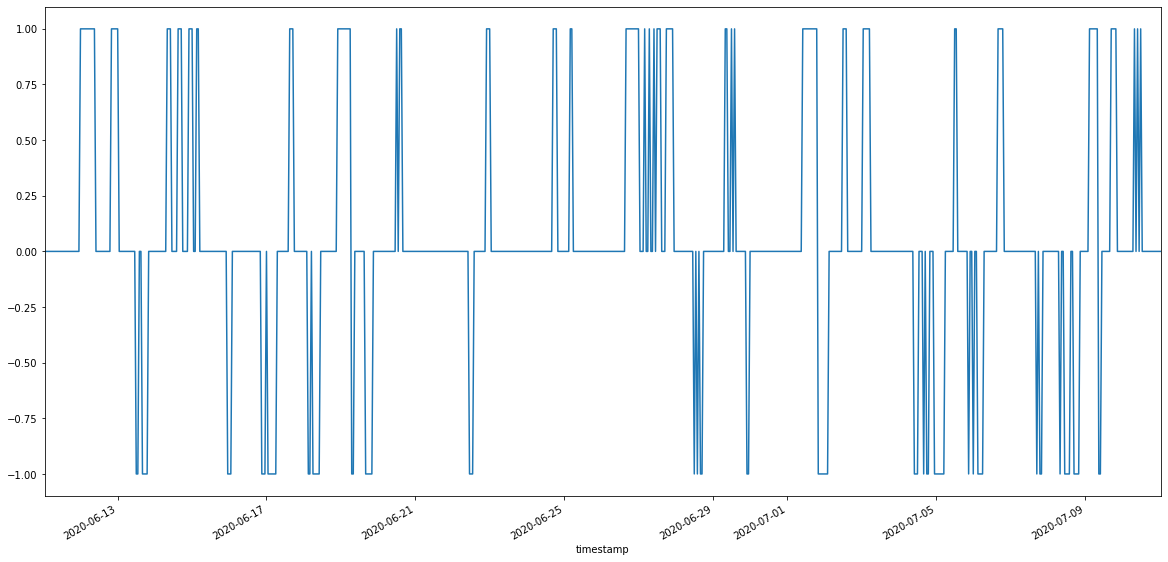

In [17]:
wtc_data['Position'].plot(figsize=(20,10))

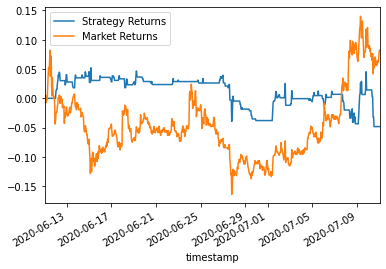

In [18]:
#Set up a column holding the daily waltonchain returns
wtc_data['Market Returns'] = wtc_data['close'].pct_change()
#Create column for Strategy Returns by multiplying the daily waltonchain returns by the position that was held at close
#of business the previous day
wtc_data['Strategy Returns'] = wtc_data['Market Returns'] * wtc_data['Position'].shift(1)
#Finally plot the strategy returns versus WTC returns
wtc_data[['Strategy Returns','Market Returns']].cumsum().plot()